In [1]:
# library import
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import wbgapi as wb
import geopandas as gpd

## Details of All Packages Used In Project

In [2]:
%load_ext watermark

In [3]:
%watermark -v -m -p numpy,scipy,sklearn 

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

numpy  : 1.23.2
scipy  : 1.9.1
sklearn: 1.1.2

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



## How to run the notebook

Create a virtual environment using python, and then install all the required packages using the provided requirements.txt file.

The commands are given below
```console
    $ python3 -m venv ./env
    $ source ./env/bin/activate
    $ pip3 install -r requirements.txt
```
After successful installation you can start the jupyter notebook by running
```console
    $ jupyter notebook
```

## Enabling Theme for Altair

In [4]:
# enable correct rendering
alt.renderers.enable('default')
# uses intermediate json files to speed things up
alt.data_transformers.enable('json')
# use the 538 theme
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

## Building custom function to get necessary columns from WDI csv Data.

In [5]:
# custom function to get necessary columns from WDI csv Data speeds up process than normal wbgapi call
def get_wdi_data(indicators, countries, years) -> pd.DataFrame:
    wdi_df = pd.read_csv('WDIData.csv')
    df = pd.DataFrame()
    for idx, indicator in enumerate(indicators):
        years_str = [str(y) for y in years]
        filtered_df = wdi_df.loc[wdi_df['Indicator Code'].isin([indicator]) & wdi_df['Country Code'].isin(countries)]
        formatted_df = pd.melt(filtered_df, id_vars=['Country Code'], value_vars=years_str, var_name='Time', value_name=indicator)
        if idx == 0:
            df = formatted_df
        else:
            df = pd.merge(df, formatted_df, on=['Country Code', 'Time'])
            
    return df

In [6]:
def get_wdi_latest_data_per_indicator(indicator) -> pd.DataFrame:
    wdi_df = pd.read_csv('WDIData.csv')
    filtered_df = wdi_df.loc[wdi_df['Indicator Code'].isin([indicator])]
    filtered_df = filtered_df.fillna(method='ffill', axis=1)[['Country Code', 'Country Name', '2021']]
    filtered_df.rename(columns = {'Country Code': 'economy', 'Country Name': 'Country', '2021': indicator}, inplace = True)
    return filtered_df

## Analyzing factors on which GDP growth of USA depends and finding correlation

In [7]:
# getting columns such as Consumer_Annual_Price , GDP_Annual_Growth, Gross_Saving, Export_Good_Service, Import_Good_Service, Unemplyment, Broad Money and Market Capitilization from dataset  
indicators=['FP.CPI.TOTL.ZG','NY.GDP.MKTP.KD.ZG','NY.GNS.ICTR.ZS','NE.EXP.GNFS.KD.ZG','NE.IMP.GNFS.KD.ZG','SL.UEM.TOTL.ZS','FM.LBL.BMNY.ZG','CM.MKT.LCAP.GD.ZS']
countries=['USA']
growth_df=get_wdi_data(indicators,countries, years=range(2000,2021))

In [8]:
growth_df.rename(columns = {'FP.CPI.TOTL.ZG':'Consumer_Price_Annual','NY.GDP.MKTP.KD.ZG':'GDP_Annual_Growth','NY.GNS.ICTR.ZS':'Gross_Saving','NE.EXP.GNFS.KD.ZG':'Export_Good_Service','NE.IMP.GNFS.KD.ZG':'Import_Good_Service','SL.UEM.TOTL.ZS':'Unemployment','FM.LBL.BMNY.ZG':'Broad_Money','CM.MKT.LCAP.GD.ZS':'Market_Capitalization'}, inplace = True)
subset_df=growth_df[['Export_Good_Service','Unemployment','Market_Capitalization','Broad_Money','Consumer_Price_Annual','Import_Good_Service','GDP_Annual_Growth','Gross_Saving']]
subset_df.head()

,Export_Good_Service,Unemployment,Market_Capitalization,Broad_Money,Consumer_Price_Annual,Import_Good_Service,GDP_Annual_Growth,Gross_Saving
0,8.311155,3.99,147.379062,8.110464,3.376857,12.999711,4.077159,20.798418
1,-5.582071,4.73,132.146653,7.932796,2.826171,-2.461286,0.954339,19.629340
2,-1.961878,5.78,101.146635,4.452193,1.586032,3.669527,1.695943,18.341058
3,2.103038,5.99,124.526145,4.403694,2.270095,5.124477,2.796209,17.391246
4,9.637181,5.53,133.612738,5.742046,2.677237,10.981441,3.852553,17.697428


In [9]:
from scipy.stats import pearsonr
corr, p = pearsonr(subset_df.GDP_Annual_Growth, subset_df.Broad_Money)
print('Pearsons correlation: %.3f' % corr)
print('P value',p)

Pearsons correlation: -0.454
P value 0.038529324857200536


### Insight
It has seen that GDP annual growth and broad money growth are negatively correlated with each other

In [10]:
#Perform scaling on dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
scaler = StandardScaler()
scaler.fit(subset_df)
scaled = scaler.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled, columns=subset_df.columns)
scaled_df.head()

,Export_Good_Service,Unemployment,Market_Capitalization,Broad_Money,Consumer_Price_Annual,Import_Good_Service,GDP_Annual_Growth,Gross_Saving
0,0.876618,-1.110587,0.550922,0.475805,1.198719,1.640486,1.251848,1.379316
1,-1.356743,-0.698689,-0.055595,0.428176,0.671041,-0.923324,-0.482184,0.736618
2,-0.774790,-0.114239,-1.289938,-0.504892,-0.517284,0.093314,-0.070388,0.028388
3,-0.121348,0.002650,-0.359024,-0.517893,0.138198,0.334580,0.540565,-0.493770
4,1.089779,-0.253394,0.002781,-0.159113,0.528329,1.305807,1.127129,-0.325447


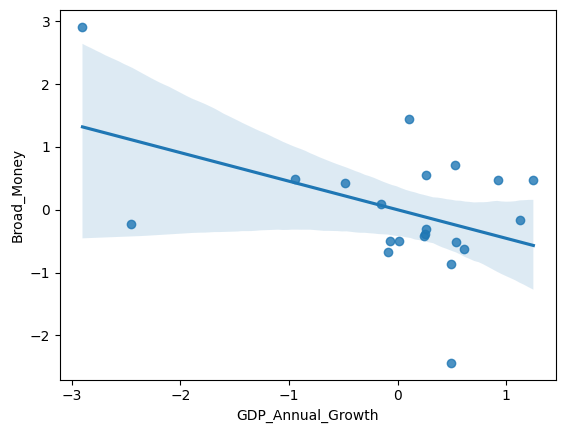

In [11]:
import seaborn as sns
sns.regplot(x ="GDP_Annual_Growth", y ="Broad_Money",data = scaled_df);

### Insight
There is a decreasing trend in GDP annual growth with increase in broad money growth

In [12]:
from scipy.stats import pearsonr
corr, p = pearsonr(scaled_df.GDP_Annual_Growth, scaled_df.Export_Good_Service)
print('Pearsons correlation: %.3f' % corr)
print('P value',p)

Pearsons correlation: 0.780
P value 2.999653341652226e-05


### Insight
There is moderate strong correlation between GDP Annual Growth and Export in Good and Services

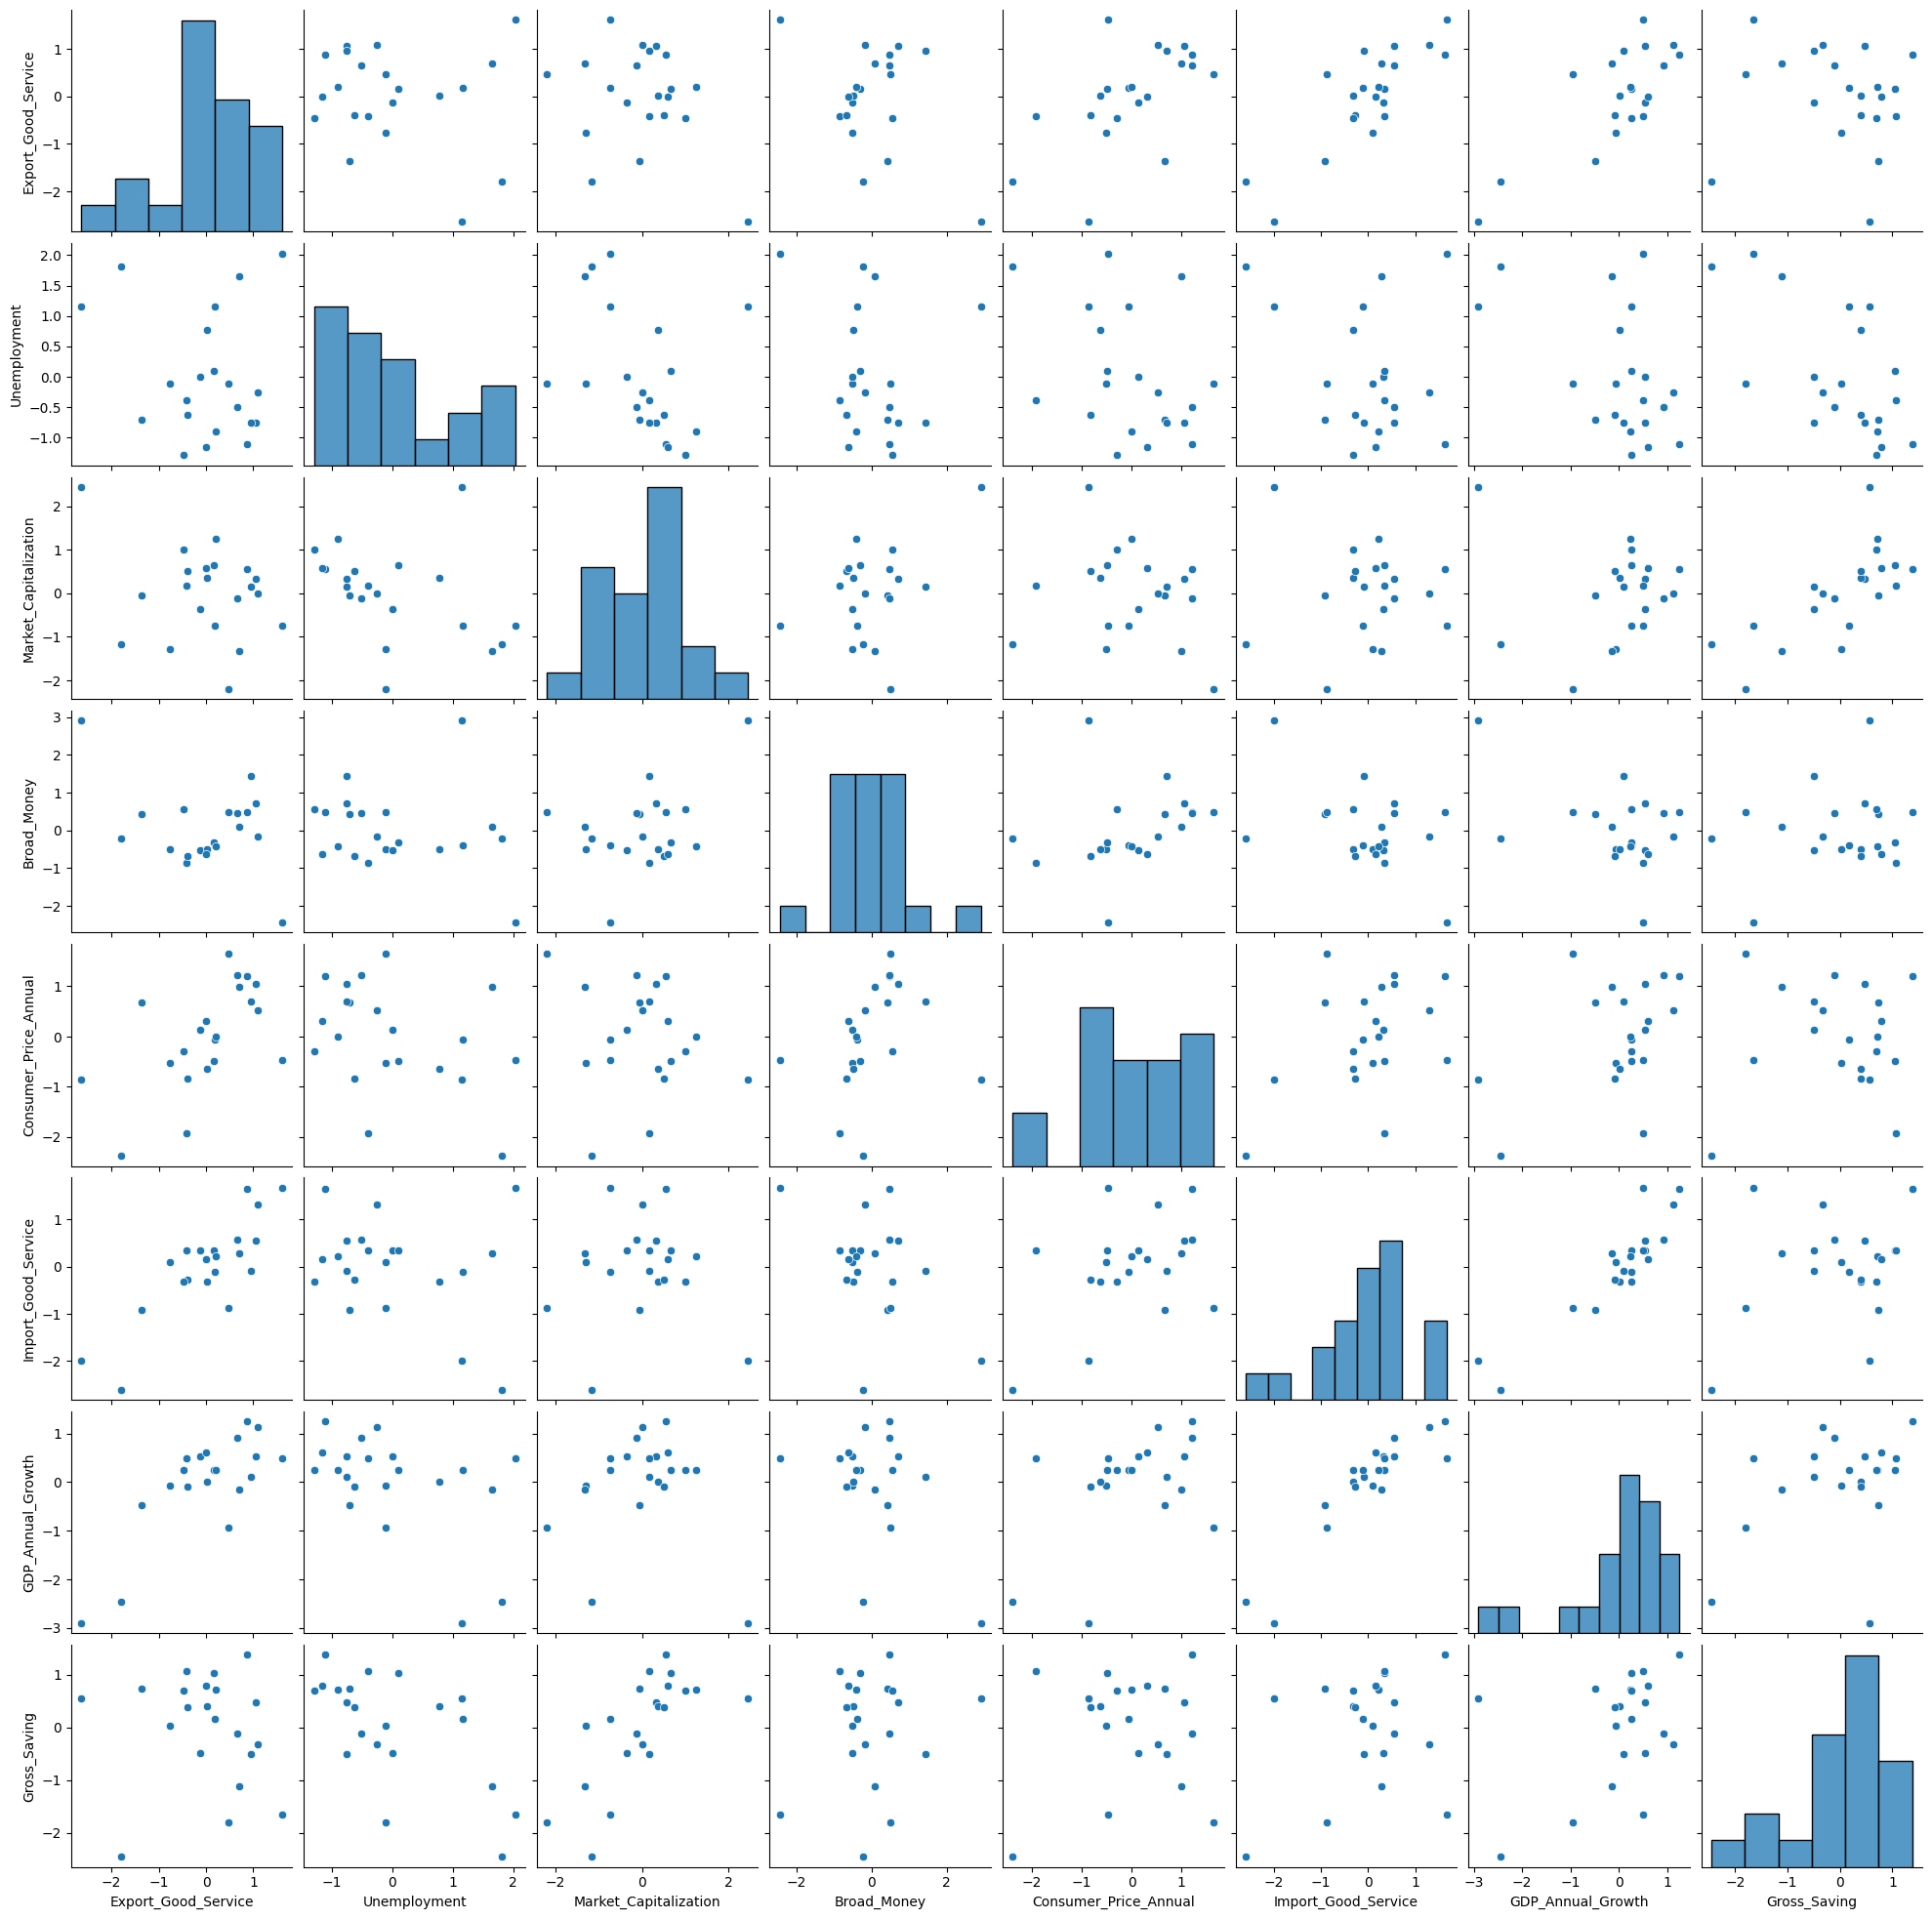

In [13]:
sns.pairplot(scaled_df)

### Insight
PairPlot showing how different variables are changing with respect to each other.

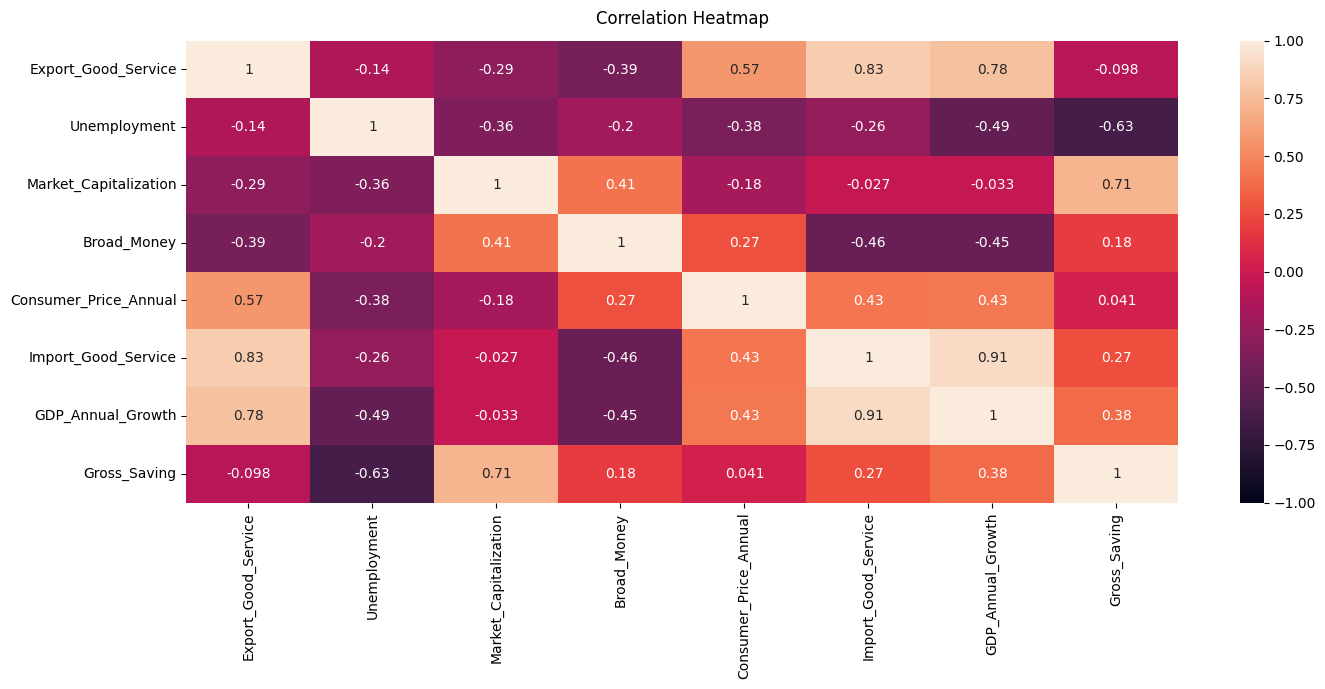

In [14]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(scaled_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Insight
Heatmap showing correlation of different variables with respect to each other. From this chart, it can be concluded

1.import good and service has strong correlation with GDP Annual growth approx 0.91

2.export good and service has moderate strong correlation with GDP growth approx 0.78

3.Market capitilization has moderate strong correlation with gross saving approx 0.71

## Analyzing countries and categorizing based on Annualized GDP growth over 10 years (2010-2020) 

In [15]:
# Get region codes from economy api using wbgapi
# this code has run one time to store the economy date into CSV
# economy_df = wb.economy.DataFrame(skipAggs=True).reset_index()
# economy_df.to_csv('economy_data.csv', index=False)
economy_df = pd.read_csv('economy_data.csv')

In [16]:
# get the total GDP column from WDI dataset csv using user defined function get_wdi_data
indicators=['NY.GDP.MKTP.CD']
countries=economy_df.id.unique()
gdp_total_df=get_wdi_data(indicators, countries, years=[2010, 2020])
gdp_total_df.rename(columns = {'NY.GDP.MKTP.CD':'GDP_Total'}, inplace = True)
gdp_total_df.head(3)

,Country Code,Time,GDP_Total
0,AFG,2010,1.585668e+10
1,ALB,2010,1.192692e+10
2,DZA,2010,1.612073e+11


In [17]:
# pivoting the table to get year in column as variable which are initially in rows
df=gdp_total_df.pivot(index = 'Country Code', columns = 'Time', values = 'GDP_Total')
#format column names
df.columns = [''.join(str(s).strip() for s in col if s) for col in df.columns]
#reset index
df.reset_index(inplace=True)
df.rename(columns = {'2010':'GDP_2010','2020':'GDP_2020'}, inplace = True)
df.head(3)

,Country Code,GDP_2010,GDP_2020
0,ABW,2.453631e+09,2.496648e+09
1,AFG,1.585668e+10,2.011614e+10
2,AGO,8.169956e+10,5.361907e+10


In [18]:
#Calculated ten years average annualized gdp growth of all countries from 2010 to 2020
def annualized_growth_pct(x0, x1, years):
    return ((x1/x0) ** (1/years) - 1)*100

df['Annualized_Growth_2010_2020'] = df.apply(lambda x: annualized_growth_pct(x.GDP_2010, x.GDP_2020, 10), axis=1)
df.head(3)

,Country Code,GDP_2010,GDP_2020,Annualized_Growth_2010_2020
0,ABW,2.453631e+09,2.496648e+09,0.173951
1,AFG,1.585668e+10,2.011614e+10,2.407847
2,AGO,8.169956e+10,5.361907e+10,-4.123988


array([[<AxesSubplot:title={'center':'Annualized_Growth_2010_2020'}>]],
      dtype=object)

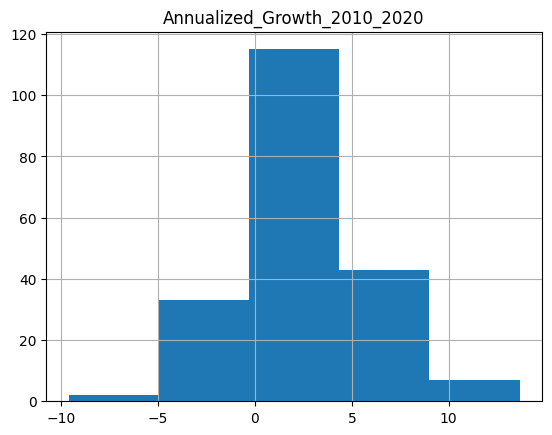

In [19]:
df1=df.sort_values(by='Annualized_Growth_2010_2020',ascending=False)
df1.dropna(inplace=True)
df1.hist(column='Annualized_Growth_2010_2020',bins=5)

### Insight
Based on Annualized GDP growth, countries are divided into 5 bins using histagram

In [20]:
# Since there are 200 countries and divided into 5 bins so each bin contains around 40 countries
df1.iloc[[0,39,79,119,159,199],-1]

61     13.654949
44      5.138862
18      3.265600
9       1.779501
140     0.075756
168    -9.613294
Name: Annualized_Growth_2010_2020, dtype: float64

### Insight

1.200 countries are divided on 5 groups based on their annuliazed GDP growth

2.High growth (>5%), medium growth (3.25%-5.1%), stable growth(1.8%-3.25%), staying static(0-1.8%), declining(<0%)

In [21]:
# logic to divide 200 countries into 5 groups based on their annualized GDP growth over 10 years
def category(x):
    if x > 5:
        return 'High Growth'
    elif 3.25<x<5.1:
        return 'Medium Growth'
    elif 1.8<x<3.25:
        return 'Stable Growth'
    elif 0<x<1.8:
        return 'Staying static'
    else:
        return 'declining'

df1['category'] = df1['Annualized_Growth_2010_2020'].apply(category)


In [22]:
categorized_gdpgrowth_df = df1

In [23]:
global_df = pd.merge(categorized_gdpgrowth_df, economy_df, how="left", left_on= "Country Code", right_on= "id")
global_df.head(3)

,Country Code,GDP_2010,GDP_2020,Annualized_Growth_2010_2020,category,id,name,aggregate,longitude,latitude,region,adminregion,lendingType,incomeLevel,capitalCity
0,ETH,2.993379e+10,1.076577e+11,13.654949,High Growth,ETH,Ethiopia,False,38.7468,9.02274,SSF,SSA,IDX,LIC,Addis Ababa
1,BGD,1.152791e+11,3.739021e+11,12.486588,High Growth,BGD,Bangladesh,False,90.4113,23.70550,SAS,SAS,IDX,LMC,Dhaka
2,DJI,1.128612e+09,3.181071e+09,10.918218,High Growth,DJI,Djibouti,False,43.1425,11.58060,MEA,MNA,IDX,LMC,Djibouti


In [24]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."


In [25]:
global_df = pd.merge(world, df1, how="left", left_on= "iso_a3", right_on= "Country Code")

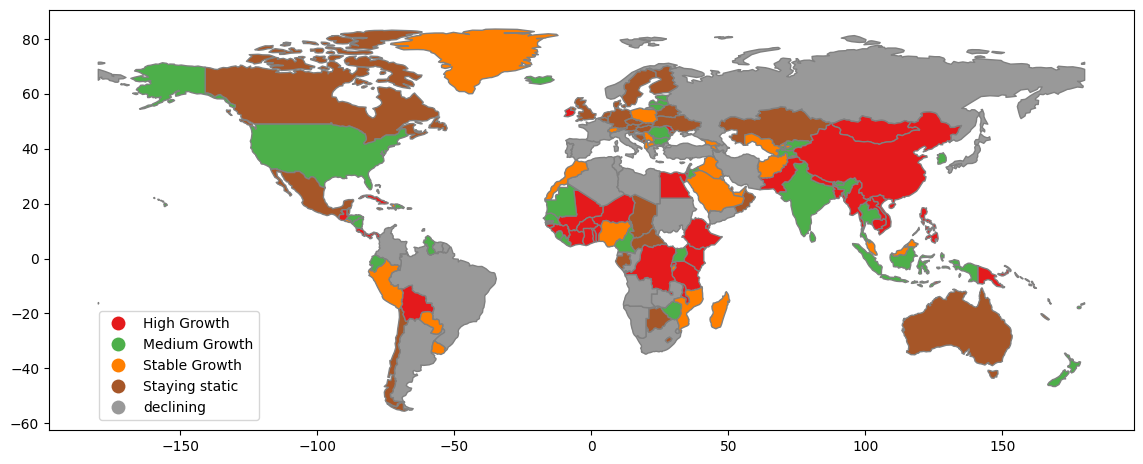

In [26]:
fig, ax = plt.subplots(1, figsize=(14,16))
global_df.plot(ax=ax,column='category', figsize=(12,4), edgecolor=u'gray', cmap='Set1', legend= True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((-0.1, 0., 0.3, 0.3))
plt.show()

### Insight
From this map, it can be visualized that growth based on annualized GDP is high for China marked with red.
Medium growth for India and USA (marked Green)
Declining growth is observed in case Russia etc marked Grey

In [27]:
df2=df1.sort_values(by=['category','GDP_2020'],ascending=[True,False])
df2.head(2)

,Country Code,GDP_2010,GDP_2020,Annualized_Growth_2010_2020,category
36,CHN,6.087164e+12,1.468767e+13,9.207836,High Growth
90,IRL,2.218760e+11,4.258890e+11,6.737887,High Growth


In [28]:
# taking top 2 countries from each category of 5 category
df2_high=df2[df2['category']=='High Growth'][:2]
df2_medium=df2[df2['category']=='Medium Growth'][:2]
df2_stable=df2[df2['category']=='Stable Growth'][:2]
df2_static=df2[df2['category']=='Staying static'][:2]
df2_decline=df2[df2['category']=='declining'][:2]
merged_gdp_df=pd.concat([df2_high,df2_medium,df2_stable,df2_static,df2_decline])
merged_gdp_df

,Country Code,GDP_2010,GDP_2020,Annualized_Growth_2010_2020,category
36,CHN,6.087164e+12,1.468767e+13,9.207836,High Growth
90,IRL,2.218760e+11,4.258890e+11,6.737887,High Growth
203,USA,1.504896e+13,2.089374e+13,3.335838,Medium Growth
89,IND,1.675615e+12,2.667688e+12,4.760140,Medium Growth
33,CHE,6.034345e+11,7.522480e+11,2.228760,Stable Growth
167,SAU,5.282073e+11,7.033678e+11,2.905315,Stable Growth
50,DEU,3.399668e+12,3.846414e+12,1.242288,Staying static
68,GBR,2.491110e+12,2.756900e+12,1.018941,Staying static
98,JPN,5.759072e+12,5.040108e+12,-1.324637,declining
64,FRA,2.645188e+12,2.630318e+12,-0.056359,declining


## Analyzing Environmental impact(CO2 Emission Per Capita) and GDP Per Capita of 10 countries listed above   

In [29]:
#Taking GDP per capita and CO2 per capita from WDI data csv using custom defined function get_wdi_data
indicators=['EN.ATM.CO2E.PC','NY.GDP.PCAP.CD']
countries=merged_gdp_df['Country Code']
gdp_CO2_df=get_wdi_data(indicators,countries, years=range(2000,2020))
gdp_CO2_df.rename(columns = {'NY.GDP.PCAP.CD':'GDP_per_capita','EN.ATM.CO2E.PC':'CO2_emission_per_capita'}, inplace = True)
gdp_CO2_df.head(10)

,Country Code,Time,CO2_emission_per_capita,GDP_per_capita
0,CHN,2000,2.650412,959.372484
1,FRA,2000,6.125508,22419.694821
2,DEU,2000,10.099316,23694.760483
3,IND,2000,0.887641,443.314194
4,IRL,2000,11.176887,26334.567205
5,JPN,2000,9.323416,39169.359570
6,SAU,2000,12.081975,9171.331476
7,CHE,2000,6.084142,38952.034201
8,GBR,2000,9.014558,28223.067571
9,USA,2000,20.469807,36329.956073


In [30]:
# this functions calculates correlation between GDP per Capita and CO2 emission per capita among 10 countries 
#These are countries which are grouped into 5 categories based on their annualized gdp growth over 10 years
def corr_find(df,countries,column1,column2):
    
    country_map=dict()
    for country in countries:
        df1=df[df['Country Code']==country]
        corr, p = pearsonr(df1[column1], df1[column2])
        country_map[country]=corr
    return country_map    
        

In [31]:
map_country=corr_find(gdp_CO2_df,['CHN','IRL','USA','IND','CHE','SAU','DEU','GBR','JPN','FRA'],'CO2_emission_per_capita','GDP_per_capita')
map_country

{'CHN': 0.9273978053136531,
 'IRL': -0.6794221979637396,
 'USA': -0.9403221412690133,
 'IND': 0.9872348563229247,
 'CHE': -0.8125073816028504,
 'SAU': 0.8916563836190118,
 'DEU': -0.7699629804573628,
 'GBR': -0.4270143256145895,
 'JPN': 0.029088130783307325,
 'FRA': -0.6583627459899798}

### Insight

1.China and India has strong positive correlation between GDP per capita and CO2 emission per capita 
means these countries are investing in clean technology and impacting environment.

2.USA and CHE(Switzerland) have shown strong negative correlation between GDP per capita and CO2 emission per capita 
This means they are environment friendly countries and not harming environment for their GDP growth


In [32]:
country_corr_df=pd.DataFrame(map_country.items(), columns=['Country_Code', 'Correlation_GDP_CO2'])
country_corr_df

,Country_Code,Correlation_GDP_CO2
0,CHN,0.927398
1,IRL,-0.679422
2,USA,-0.940322
3,IND,0.987235
4,CHE,-0.812507
5,SAU,0.891656
6,DEU,-0.769963
7,GBR,-0.427014
8,JPN,0.029088
9,FRA,-0.658363


In [33]:
# bar chart to show correlation between GDP per capita and CO2 emission per capita of 10 countries 
bar_chart=alt.Chart(country_corr_df).mark_bar(width=20).encode(
    x=alt.X('Country_Code:N'),
    y=alt.Y('Correlation_GDP_CO2:Q'),
    color=alt.condition(
      alt.datum.Correlation_GDP_CO2 > 0,
      alt.value("red"),  # The positive color
      alt.value("green") 
   
    )
    
).properties(
        width=500,
        height=400,
        title={
      "text": ["Correlation Between GDP Per Capita and CO2 Emission Per Capita"], 
      "color": "black",
      "subtitleColor": "gray",
      "subtitleFontSize": 15
}
    ) 
bar_chart

alt.Chart(...)

### Insight

1.Countries which strong negative correlation between GDP per Capita and CO2 per Capita are marked with green color 
means they are environment friendly

2.Countries which strong positive correlation between GDP per Capita and CO2 per Capita are marked with red color 
means they are not environment friendly. 

In [34]:
# scatter plot to visualize trend between gdp per capita and CO2 emission per capita between 10 countries 
domain = ['CHN', 'IRL','USA','IND','CHE','SAU','DEU','GBR','JPN','FRA']
range_ = ['#317216', '#52be25', '#ff5d00','#ff9e66','#ff0051', '#ff80a8','#7700ff','#c999ff','#001fff','#808fff']
chart=alt.Chart(gdp_CO2_df).mark_circle().encode(
    x=alt.X('CO2_emission_per_capita:Q'),
    y=alt.Y('GDP_per_capita:Q'),
   
    color=alt.Color('Country Code:N',scale=alt.Scale(domain=domain, range=range_)),
    
) 
chart

alt.Chart(...)

### Insight
From this chart we can infer that countries such USA and CHN(Switzerland) are showing decreasing trend which is good
means with increase in GDP per capita there is decrease in CO2 emission per capita whereas reverse trend is observed 
in case of countries such as India and China

In [35]:
df2=gdp_CO2_df.groupby('Time')[['CO2_emission_per_capita','GDP_per_capita']].sum().reset_index()
df2.head(3)

,Time,CO2_emission_per_capita,GDP_per_capita
0,2000,87.913663,225697.458077
1,2001,88.516113,223627.147545
2,2002,87.475567,235957.384707


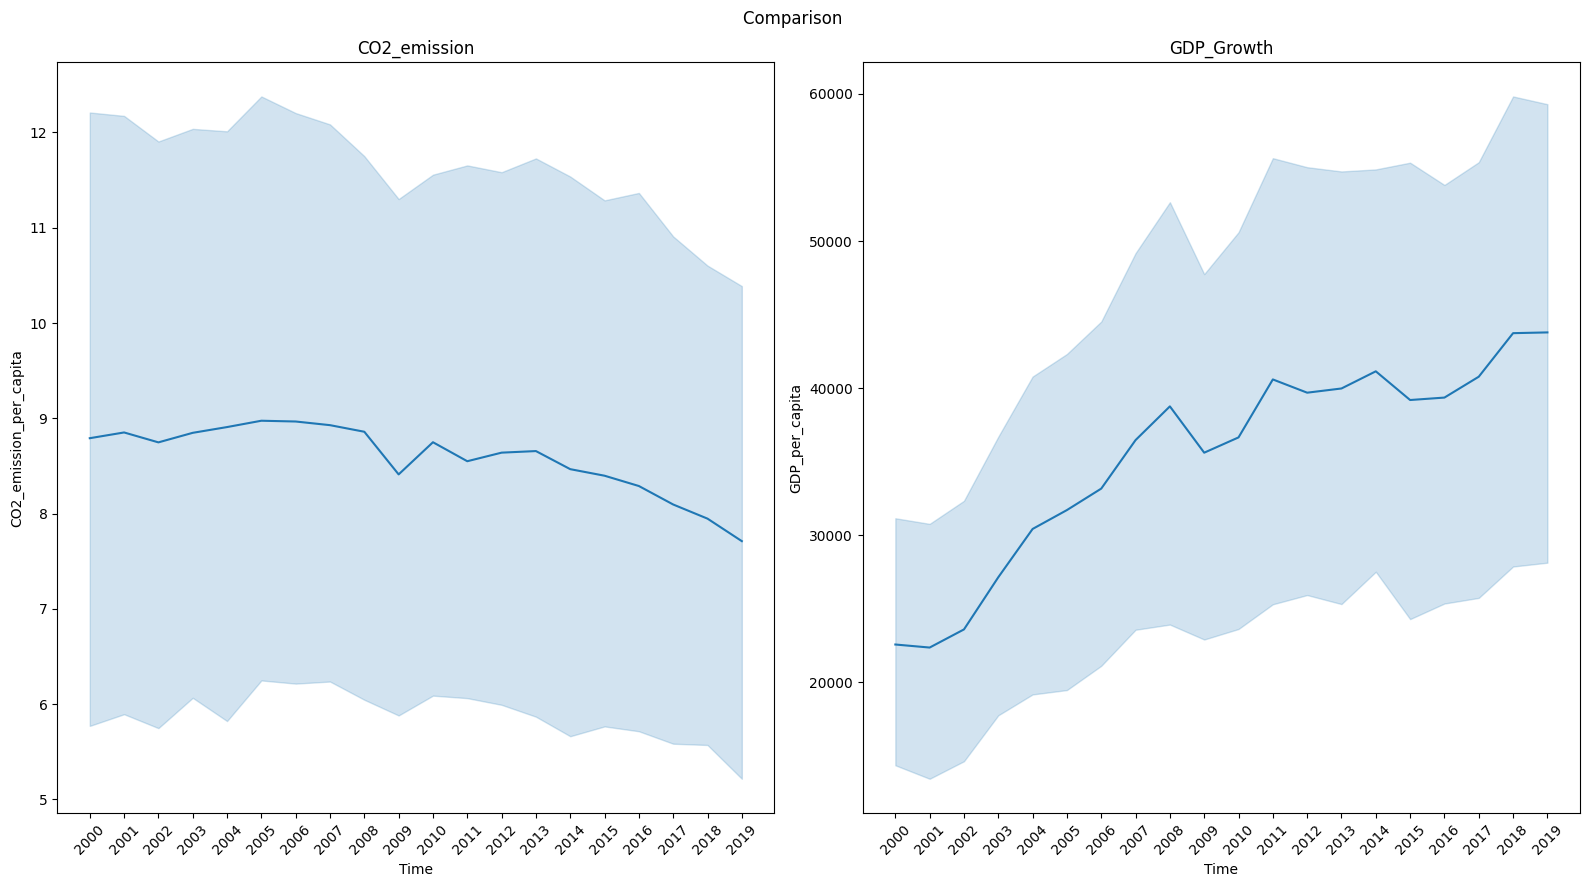

In [36]:
fig, axes = plt.subplots(1, 2,figsize=(16,9))

sns.lineplot(x = 'Time', y = 'CO2_emission_per_capita',data = gdp_CO2_df, ax = axes[0])
sns.lineplot(x = 'Time', y = 'GDP_per_capita',data = gdp_CO2_df, ax = axes[1])
axes[0].set_title("CO2_emission")
axes[1].set_title("GDP_Growth")
plt.suptitle("Comparison ")
axes[0].tick_params(axis='x', labelrotation = 45)
axes[1].tick_params(axis='x', labelrotation = 45)

plt.tight_layout()

### Insight

1.The first chart representing trend in CO2 emission per capita from 2000 to 2019 where we can see decrease in CO2 trend over recent years
2. The second chart showing increasing trend in GDP per capita which is expected

## Finding out Trends of Market capitilization of 10 countries with respect to GDP 

In [37]:
#Getting column market capitilization from WDI CSV file using custom function get_wdi_data
indicators=['CM.MKT.LCAP.GD.ZS']
countries=merged_gdp_df['Country Code']
market_cap_df=get_wdi_data(indicators,countries, years=range(2000,2021))
market_cap_df.rename(columns = {'CM.MKT.LCAP.GD.ZS':'Market_Cap'}, inplace = True)
market_cap_df.head(3)

,Country Code,Time,Market_Cap
0,CHN,2000,NaN
1,FRA,2000,105.930881
2,DEU,2000,65.208158


In [38]:
market_cap_df.isnull().sum()

Country Code     0
Time             0
Market_Cap      22
dtype: int64

### Insight
There are 22 missing data for market capitilization for these 10 countries

In [39]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
market_cap_df['Market_Cap']= imputer.fit_transform(market_cap_df['Market_Cap'].values.reshape(-1,1))
market_cap_df.head(3)

,Country Code,Time,Market_Cap
0,CHN,2000,96.849527
1,FRA,2000,105.930881
2,DEU,2000,65.208158


### Insight
Used KNN regressor to compute 22 missing values

In [40]:
market_cap_df.isnull().sum()

Country Code    0
Time            0
Market_Cap      0
dtype: int64

In [41]:
# convert time with datatype as object to date time using datetime function
market_cap_df['Time']=pd.to_datetime(market_cap_df['Time'])

In [42]:
domain = ['CHN', 'IRL','USA','IND','CHE','SAU','DEU','GBR','JPN','FRA']
range_ = ['#317216', '#52be25', '#ff5d00','#ff9e66','#ff0051', '#ff80a8','#7700ff','#c999ff','#001fff','#808fff']

chart=alt.Chart(market_cap_df).mark_line(width=20).encode(
    x=alt.X('Time:T'),
    y=alt.Y('Market_Cap:Q'),
   
    color=alt.Color('Country Code:N',scale=alt.Scale(domain=domain, range=range_))
    
).properties(
        width=500,
        height=400,
        title={
      "text": ["Market Growth with respect to GDP"], 
      "color": "black",
      "subtitleColor": "gray",
      "subtitleFontSize": 15
}
    )  
chart

alt.Chart(...)

### Insight
Countries like SAU(Saudia Arabia) and CHN (China) show sharp increase in market capitilization value(how stock is changing with respect to GDP)
from year 2018 to year 2020

## Analyzing contribution towards total GDP by all countries(~200) based on different income levels

In [43]:
#Getting total GDP in current US dollar from WDI csv data using custom function get_wdi_data
indicators=['NY.GDP.MKTP.CD']
countries=economy_df.id.unique()
GDPpc_long=get_wdi_data(indicators,countries, years=range(2000,2021))
#Merging with economy dataframe to get information about income level of countries
GDPwithIncome = pd.merge(GDPpc_long, economy_df, how="left", left_on= "Country Code", right_on= "id")
GDPwithIncome.head(3)

,Country Code,Time,NY.GDP.MKTP.CD,id,name,aggregate,longitude,latitude,region,adminregion,lendingType,incomeLevel,capitalCity
0,AFG,2000,NaN,AFG,Afghanistan,False,69.17610,34.5228,SAS,SAS,IDX,LIC,Kabul
1,ALB,2000,3.480355e+09,ALB,Albania,False,19.81720,41.3317,ECS,ECA,IBD,UMC,Tirane
2,DZA,2000,5.479039e+10,DZA,Algeria,False,3.05097,36.7397,MEA,MNA,IBD,LMC,Algiers


#### Finding total GDP Contribution of countries on the basis of Time and Income Level using Group By Function

In [44]:
income_level_df=GDPwithIncome.groupby(['Time','incomeLevel'])['NY.GDP.MKTP.CD'].sum()
df_income=income_level_df.reset_index(level='incomeLevel')
df=df_income.rename(columns={'NY.GDP.MKTP.CD':'Total_GDP_Per_Income_Group'}).reset_index()
df_cleaned = df.dropna()
df_cleaned.head(3)


,Time,incomeLevel,Total_GDP_Per_Income_Group
0,2000,HIC,2.741059e+13
1,2000,INX,1.171407e+11
2,2000,LIC,1.729259e+11


In [45]:
# Finding total GDP each year 
total_income_df=GDPwithIncome.groupby(['Time'])['NY.GDP.MKTP.CD'].sum()
total_df=total_income_df.reset_index(name='Total_GDP')
total_df.head(3)

,Time,Total_GDP
0,2000,3.346525e+13
1,2001,3.327844e+13
2,2002,3.457732e+13


In [46]:
# Merging total gdp contibution each year dataframe and gdp contribution each year by each country
merge_df=total_df.merge(df_cleaned)
merge_df = merge_df[merge_df.incomeLevel != 'INX']
merge_df.head(3)

,Time,Total_GDP,incomeLevel,Total_GDP_Per_Income_Group
0,2000,3.346525e+13,HIC,2.741059e+13
2,2000,3.346525e+13,LIC,1.729259e+11
3,2000,3.346525e+13,LMC,1.520272e+12


In [47]:
# creating new column in dataframe merged_df
merge_df['GDP_contribution_percentage']=(merge_df['Total_GDP_Per_Income_Group']/merge_df['Total_GDP'])*100
merge_df.head(3)

,Time,Total_GDP,incomeLevel,Total_GDP_Per_Income_Group,GDP_contribution_percentage
0,2000,3.346525e+13,HIC,2.741059e+13,81.907613
2,2000,3.346525e+13,LIC,1.729259e+11,0.516733
3,2000,3.346525e+13,LMC,1.520272e+12,4.542838


In [48]:
# converting object type to data time
merge_df['Time']=pd.to_datetime(merge_df['Time'])

In [49]:
import altair as alt
domain = ['HIC', 'LIC', 'LMC', 'UMC']
range_ = ['gray', 'orange', 'darkorange', 'orangered']

bar_chart=alt.Chart(merge_df).mark_bar(width=20).encode(
    x=alt.X('Time:T',title='Year'),
    y=alt.Y('Total_GDP_Per_Income_Group:Q', stack='zero',title='Total GDP'),
   
    color=alt.Color('incomeLevel:N', scale=alt.Scale(domain=domain, range=range_)),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'incomeLevel',
      sort='ascending'
    )
) 

text = alt.Chart(merge_df).mark_text(dx=0, dy=5, color='white').encode(
    x='Time:T',
    y=alt.Y('Total_GDP_Per_Income_Group:Q', stack='zero'),
    detail='incomeLevel:N',
    text=alt.Text('GDP_contribution_percentage:Q', format='.0f'),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'incomeLevel',
      sort='ascending'
    )
).transform_filter(
    (alt.datum.incomeLevel != 'LIC') & (alt.datum.incomeLevel != 'INX')
 
)

chart=(bar_chart + text).properties(
        width=700,
        height=300,
        title={
      "text": ["Middle-income countries' share of the global economy has accelerated"], 
      "color": "black",
      "subtitleColor": "gray",
      "subtitleFontSize": 15
}
    )
chart

alt.LayerChart(...)

### Insight
It can be concluded that over recent years total GDP contribution by upper middle income country and 
lower middle group countries has increased

#### Getting Trend of GDP Contribution by High Income group Countries, Upper Middle Countries Income, Lower Middle Countries 

In [50]:
indicators=['NY.GDP.MKTP.CD']
countries=economy_df.id.unique()
GDP_per_capita=get_wdi_data(indicators,countries, years=range(2000,2021))
GDP_df = pd.merge(GDP_per_capita, economy_df, how="left", left_on= "Country Code", right_on= "id")
Income_df=GDP_df[(GDP_df['incomeLevel']=='LMC') | (GDP_df['incomeLevel']=='UMC') | (GDP_df['incomeLevel']=='HIC')]
Income_df.head(3)

,Country Code,Time,NY.GDP.MKTP.CD,id,name,aggregate,longitude,latitude,region,adminregion,lendingType,incomeLevel,capitalCity
1,ALB,2000,3.480355e+09,ALB,Albania,False,19.81720,41.3317,ECS,ECA,IBD,UMC,Tirane
2,DZA,2000,5.479039e+10,DZA,Algeria,False,3.05097,36.7397,MEA,MNA,IBD,LMC,Algiers
3,ASM,2000,NaN,ASM,American Samoa,False,-170.69100,-14.2846,EAS,EAP,LNX,UMC,Pago Pago


In [51]:
income_series=Income_df.groupby(['Time','incomeLevel'])['NY.GDP.MKTP.CD'].mean()
income_df=income_series.unstack('incomeLevel').rename_axis(columns=None)
income_df1 = income_df.reset_index()
income_df1['High Income Countries']=income_df1['HIC']/income_df1['HIC'][0]
income_df1['MIC']=income_df1['LMC']+income_df1['UMC']
income_df1['Middle Income Countries']=income_df1['MIC']/income_df1['MIC'][0]
income_df1=income_df1.drop(columns=['LMC','UMC','HIC','MIC'],axis=1)
income_df2 = pd.melt(income_df1, id_vars=['Time'], value_vars=['High Income Countries', 'Middle Income Countries'],var_name='income_type', value_name='gdp_percent')
income_df2.head(3)

,Time,income_type,gdp_percent
0,2000,High Income Countries,1.000000
1,2001,High Income Countries,0.990982
2,2002,High Income Countries,0.990735


In [52]:
chart=alt.Chart(income_df2).mark_line().encode(
    x='Time:T',
    y='gdp_percent:Q',
    color=alt.Color('income_type:N',scale=alt.Scale(range=['gray', 'red']))
)
chart

alt.Chart(...)

### Insight
From this chart, it can be concluded that trend for contribution to total GDP  by Middle Income Group Countries(UMC,LMC)
is increasing at much faster rate than High Income Group Countries. 

## Analyzing growth of Rural Population and Urban Population of all countries over years (2000-2020)

In [53]:
# getting population parameter of both type of population from WDI dataset
indicators=['SP.RUR.TOTL','SP.URB.TOTL']
countries=economy_df.id.unique()
population_df=get_wdi_data(indicators,countries, years=range(2000,2021))
population_df.rename(columns = {'SP.RUR.TOTL':'Rural_Population','SP.URB.TOTL':'Urban_Population'}, inplace = True)
population_df.head(3)

,Country Code,Time,Rural_Population,Urban_Population
0,AFG,2000,16192158.0,4587799.0
1,ALB,2000,1799636.0,1289391.0
2,DZA,2000,12442039.0,18600199.0


In [54]:
# Aggregating population of both type of all countries based on time
pop_chg_df=population_df.groupby('Time').agg({'Rural_Population':'sum','Urban_Population':'sum'})
pop_chg_df.reset_index(inplace=True)
pop_tidy_df=pd.melt(pop_chg_df,id_vars='Time', value_vars=['Urban_Population','Rural_Population'],var_name='Population_Type', value_name='Population_total')
pop_tidy_df.head(3)

,Time,Population_Type,Population_total
0,2000,Urban_Population,2.838437e+09
1,2001,Urban_Population,2.903025e+09
2,2002,Urban_Population,2.971363e+09


In [55]:
# Changing datatype
pop_tidy_df['Time']=pd.to_datetime(pop_tidy_df['Time'])

In [56]:
bar_chart=alt.Chart(pop_tidy_df).mark_bar(width=20).encode(
    x=alt.X('Time:T',title='Year'),
    y=alt.Y('Population_total:Q', stack='zero',title='Total Population'),
   
    color=alt.Color('Population_Type:N'),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Population_Type',
      sort='ascending'
    )
).properties(
        width=700,
        height=300,
        title={
      "text": ["Urban Population has increased more than Rural Population"], 
      "color": "black",
      "subtitleColor": "gray",
      "subtitleFontSize": 15
}
    ) 

bar_chart

alt.Chart(...)

### Insight
It can be concluded from chart that Urban Population has increased more than Rural Population over years(2000-2020).
There is no as such increase in Rural population, it is almost static over 20 years.

### Conclusions

1.Strong correlation is observed between GDP Growth and Growth in Export and Import Good And Services for USA

2.200 countries are categorized into 5 buckets based on annualized GDP growth over 10 years which are as follows

    1.High Growth
    
    2.Medium Growth
    
    3.Stable Growth
    
    4.Staying Static
    
    5.Declining
    
3.Environmental impact (CO2 emission per capita) and GDP per capita of bucketed countries are analyzed.
  Developed countries reduced their environmental impact whereas developing countries are still struggling to mitigate the situation.

4.Trend for Market capitilization values increases only some of countries out of 10 countries with respect to GDP    
    
5.Increasing trends in contribution to total GDP of world are observed in case of Middle Income Countries

6.In case of population, total population for urban areas has steadily increased over 20 years (2000-2020)
whereas total population for rural areas are almost static.